In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision diffusers transformers accelerate matplotlib scikit-image tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhaypherali","key":"859f3b85bfb14b823365766df25ebae5"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip -q lgg-mri-segmentation.zip

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 97% 690M/714M [00:02<00:00, 254MB/s]
100% 714M/714M [00:02<00:00, 340MB/s]


--- Loading pre-trained models for inference ---
Models loaded successfully. Generating a new image...

--- Stage 3: Generating New Image ---


Generating Image:   0%|          | 0/1000 [00:00<?, ?it/s]

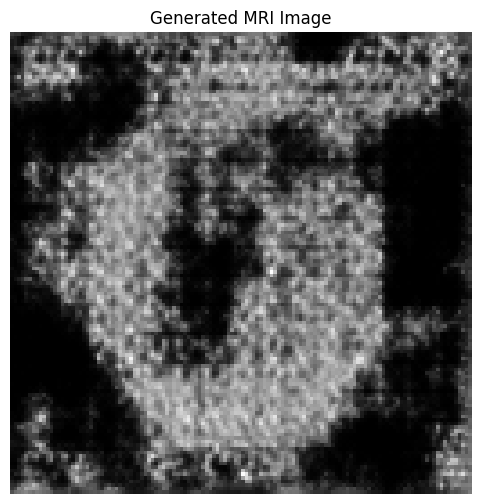

Generated image saved to /content/drive/My Drive/MRI_Project_Outputs_More_Epochs/generated_mri.png


In [10]:

# ==============================================================================
# ==  1. IMPORTS & CONFIGURATION  =============================================
# ==============================================================================

import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import UNet2DModel, DDPMScheduler
from accelerate import Accelerator
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
# This dictionary holds all the hyperparameters for our models and training loops.
config = {
    "dataset_path": "./lgg-mri-segmentation/kaggle_3m",
    "image_size": 128,
    "batch_size": 16,
    "latent_channels": 128,
    "latent_size": 16,
    "ae_epochs": 75, #was 50 on first training
    "ae_lr": 1e-4,
    "unet_epochs": 150, #was 100 on first training
    "unet_lr": 1e-4,
    "num_train_timesteps": 1000,
    "save_dir": "/content/drive/My Drive/MRI_Project_Outputs_More_Epochs",
}

# Create the output directory if it doesn't exist
os.makedirs(config["save_dir"], exist_ok=True)


# ==============================================================================
# ==  2. DATA PREPARATION CLASS ===============================================
# ==============================================================================

class MRIDataset(Dataset):
    """Custom PyTorch Dataset for loading the MRI scans."""
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, '*/*[0-9].tif'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image


# ==============================================================================
# ==  3. AUTOENCODER MODEL ARCHITECTURE  =======================================
# ==============================================================================
class Encoder(nn.Module):
    def __init__(self, latent_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, latent_channels, kernel_size=3, stride=2, padding=1),
        )
    def forward(self, x): return self.model(x)

class Decoder(nn.Module):
    def __init__(self, latent_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    def forward(self, x): return self.model(x)

class Autoencoder(nn.Module):
    def __init__(self, latent_channels):
        super().__init__()
        self.encoder = Encoder(latent_channels)
        self.decoder = Decoder(latent_channels)
    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

# ==============================================================================
# ==  4. AUTOENCODER TRAINING  =================================================
# ==============================================================================

def train_autoencoder(dataloader):
    print("--- Stage 1: Training Autoencoder ---")
    accelerator = Accelerator()
    device = accelerator.device
    autoencoder = Autoencoder(config["latent_channels"]).to(device)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=config["ae_lr"])
    criterion = nn.MSELoss()
    dataloader_acc, autoencoder, optimizer = accelerator.prepare(dataloader, autoencoder, optimizer)

    for epoch in range(config["ae_epochs"]):
        progress_bar = tqdm(total=len(dataloader_acc), desc=f"Epoch {epoch + 1}/{config['ae_epochs']}")
        for batch in dataloader_acc:
            images = batch.to(device)
            optimizer.zero_grad()
            reconstructed_images = autoencoder(images)
            loss = criterion(reconstructed_images, images)
            accelerator.backward(loss)
            optimizer.step()
            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.item())
        progress_bar.close()

    ae_save_path = os.path.join(config["save_dir"], "autoencoder.pth")
    unwrapped_ae = accelerator.unwrap_model(autoencoder)
    torch.save(unwrapped_ae.state_dict(), ae_save_path)
    print(f"Autoencoder training finished. Model saved to {ae_save_path}")
    return unwrapped_ae

# ==============================================================================
# ==  5. DIFFUSION MODEL (U-NET) TRAINING  =====================================
# ==============================================================================

def train_diffusion_model(autoencoder, dataloader):
    print("\n--- Stage 2: Training Diffusion U-Net ---")
    autoencoder.eval()
    for param in autoencoder.parameters():
        param.requires_grad = False

    accelerator = Accelerator()
    device = accelerator.device
    unet = UNet2DModel(
        sample_size=config["latent_size"], in_channels=config["latent_channels"],
        out_channels=config["latent_channels"], layers_per_block=2,
        block_out_channels=(128, 128, 256),
        down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
        up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    )
    noise_scheduler = DDPMScheduler(num_train_timesteps=config["num_train_timesteps"])
    unet.to(device)
    autoencoder.to(device)
    optimizer = torch.optim.Adam(unet.parameters(), lr=config["unet_lr"])
    unet, optimizer, dataloader_acc = accelerator.prepare(unet, optimizer, dataloader)

    for epoch in range(config["unet_epochs"]):
        progress_bar = tqdm(total=len(dataloader_acc), desc=f"Epoch {epoch + 1}/{config['unet_epochs']}")
        for batch in dataloader_acc:
            images = batch.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                clean_latents = autoencoder.encoder(images)
            noise = torch.randn_like(clean_latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (clean_latents.shape[0],), device=device).long()
            noisy_latents = noise_scheduler.add_noise(clean_latents, noise, timesteps)
            noise_pred = unet(noisy_latents, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            optimizer.step()
            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.item())
        progress_bar.close()

    unet_save_path = os.path.join(config["save_dir"], "unet.pth")
    accelerator.wait_for_everyone()
    unwrapped_unet = accelerator.unwrap_model(unet)
    torch.save(unwrapped_unet.state_dict(), unet_save_path)
    print(f"U-Net training finished. Model saved to {unet_save_path}")
    return unwrapped_unet

# ==============================================================================
# ==  6. INFERENCE (IMAGE GENERATION) - CORRECTED  =============================
# ==============================================================================

def generate_image(unet, autoencoder):
    """Generates and displays a new image, ensuring all components are on the correct device."""
    print("\n--- Stage 3: Generating New Image ---")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    unet.to(device)
    autoencoder.to(device)
    unet.eval()
    autoencoder.eval()

    scheduler = DDPMScheduler(num_train_timesteps=config["num_train_timesteps"])

    # CORRECTED: Create a generator on the correct device to fix the runtime error.
    generator = torch.Generator(device=device)
    generator.manual_seed(19) # for reproducibility

    latents = torch.randn(
        (1, config["latent_channels"], config["latent_size"], config["latent_size"]),
        generator=generator,
        device=device,
    )

    scheduler.set_timesteps(config["num_train_timesteps"])
    progress_bar = tqdm(scheduler.timesteps, desc="Generating Image")
    for t in progress_bar:
        with torch.no_grad():
            noise_pred = unet(latents, t).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    with torch.no_grad():
        generated_image = autoencoder.decoder(latents)

    generated_image = (generated_image + 1) / 2
    generated_image = generated_image.clamp(0, 1)
    img_np = generated_image[0].cpu().permute(1, 2, 0).numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np, cmap='gray')
    plt.title("Generated MRI Image")
    plt.axis('off')
    save_path = os.path.join(config["save_dir"], "generated_mri.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Generated image saved to {save_path}")


# ==============================================================================
# ==  7. MAIN EXECUTION BLOCK (SMART VERSION) =================================
# ==============================================================================

def main():
    """
    Main function that first checks if models are already trained.
    If they are, it loads them and generates an image.
    If not, it runs the full training process.
    """
    ae_path = os.path.join(config["save_dir"], "autoencoder.pth")
    unet_path = os.path.join(config["save_dir"], "unet.pth")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if os.path.exists(ae_path) and os.path.exists(unet_path):
        print("--- Loading pre-trained models for inference ---")

        # Initialize model architectures
        trained_autoencoder = Autoencoder(config["latent_channels"])
        trained_unet = UNet2DModel(
            sample_size=config["latent_size"], in_channels=config["latent_channels"],
            out_channels=config["latent_channels"], layers_per_block=2,
            block_out_channels=(128, 128, 256),
            down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
        )

        # Load the saved weights and ensure they are on the correct device
        trained_autoencoder.load_state_dict(torch.load(ae_path, map_location=device))
        trained_unet.load_state_dict(torch.load(unet_path, map_location=device))

        print("Models loaded successfully. Generating a new image...")
        generate_image(trained_unet, trained_autoencoder)
        return

    print("--- Pre-trained models not found. Starting full training process. ---")

    transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

    try:
        dataset = MRIDataset(root_dir=config["dataset_path"], transform=transform)
        if len(dataset) == 0:
            raise FileNotFoundError(f"No image files were found in the directory '{config['dataset_path']}'.")
        dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)
        print(f"Successfully loaded {len(dataset)} images.")
    except FileNotFoundError as e:
        print(f"\n[Dataset Error] {e}")
        return

    trained_autoencoder = train_autoencoder(dataloader)
    trained_unet = train_diffusion_model(trained_autoencoder, dataloader)
    generate_image(trained_unet, trained_autoencoder)

if __name__ == "__main__":
    main()
